In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(842663, 112)



# Triage Accuracy

(How many patients did they get right and do they do it in the right order, for example: still or obvious life threat first (Red, Gray, Black), then wavers, then walkers last.)


### Adjusted R-squared

I am using the adjusted R-squared value of a linear regression model fit as a measure of how well responders engaged the still first, then wavers, then walkers last. A score of 1.0 will mean that the responder performed the ideal sequence. A score of -1.0 means that the responder performed the opposite sequence.

The algorithm will work for any number of patients. It allows for any number of still patients, which will be correctly placed in the beginning of the ideal sequence. The numbers are just the milliseconds of elapsed time at the engagement of a patient. The scenes are zero-indexed _SESSION_START_ to _SESSION_END_ segments. Time group 1 is the 2nd session in the file, for instance.

This is possibly also a measure of Tolerance for Risk (see https://nextcentury.atlassian.net/wiki/spaces/ITMC/pages/2998960129/KDMAs).

In [4]:

# Create a dataset of measures of right ordering
if nu.pickle_exists('engagment_sort_df'):
    engagment_sort_df = nu.load_object('engagment_sort_df')
else:
    
    # Group the data by session and scene
    import statsmodels.api as sm
    groupby_columns = ['session_uuid', 'scene_index']
    gb = frvrs_logs_df.groupby(groupby_columns)
    
    # Iterate over each run to get the data rows
    rows_list = []
    for (session_uuid, scene_index), df1 in gb:
        row_dict = {}
        
        # Populate the row_dict with values from the groupby_columns
        for cn in groupby_columns: row_dict[cn] = eval(cn)
        
        # Add the logger version and scene categories
        logger_version = df1.logger_version.unique().item()
        row_dict['logger_version'] = logger_version
        is_scene_aborted = df1.is_scene_aborted.unique().item()
        row_dict['is_scene_aborted'] = is_scene_aborted
        scene_type = df1.scene_type.unique().item()
        row_dict['scene_type'] = scene_type
    
        # Set the last engagement time among all the obvious life threats
        assert ('tag_applied_type' in df1.columns)
        mask_series = df1.tag_applied_type.isin(['red', 'gray', 'black'])
        df = df1[mask_series]
        if df.shape[0]:
            # display(df.sample(min(4, df[mask_series].shape[0])).dropna(axis='columns', how='all').T)
            patient_ids_list = df.patient_id.unique().tolist()
            mask_series = True
            for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))
            mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
            mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')
            row_dict['last_threat_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()
    
        # Group the patients by engagement SORT category and get lists of their elapsed times
        engaged_sort_dict = {}
        for patient_engaged_sort, df2 in df1.groupby('patient_engaged_sort'):
            if patient_engaged_sort in ['still', 'waver', 'walker']:

                # Get the scene's entire history
                mask_series = True
                for cn in groupby_columns: mask_series &= (frvrs_logs_df[cn] == eval(cn))

                # Filter by the engaged stills, walkers or wavers
                patient_ids_list = df2.patient_id.unique().tolist()
                mask_series &= frvrs_logs_df.patient_id.isin(patient_ids_list)
                mask_series &= (frvrs_logs_df.action_type == 'PATIENT_ENGAGED')

                # Set the engaged sort stuff
                row_dict[f'last_{patient_engaged_sort}_engaged'] = frvrs_logs_df[mask_series].elapsed_time.max()
                engaged_sort_dict[patient_engaged_sort] = frvrs_logs_df[mask_series].sort_values(
                    ['elapsed_time']
                ).elapsed_time.tolist()
        
        # Get an R-squared Adjusted as a measure of right ordering
        ideal_sequence = []
        for sort in ['still', 'waver', 'walker']: ideal_sequence.extend(engaged_sort_dict.get(sort, []))
        ideal_sequence = pd.Series(data=ideal_sequence)
        actual_sequence = ideal_sequence.sort_values(ascending=True)
        X, y = ideal_sequence.values.reshape(-1, 1), actual_sequence.values.reshape(-1, 1)
        if X.shape[0]:
            X1 = sm.add_constant(X)
            try: rsquared_adj = sm.OLS(y, X1).fit().rsquared_adj
            except: rsquared_adj = np.nan
            row_dict['rsquared_adj'] = rsquared_adj
        
        rows_list.append(row_dict)
    
    engagment_sort_df = DataFrame(rows_list)
    nu.store_objects(engagment_sort_df=engagment_sort_df)

In [5]:

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
display(engagment_sort_df.sample(min(4, engagment_sort_df.shape[0])).dropna(axis='columns', how='all').T)

,136,721,282,771
logger_version,1.3,1.0,1.3,1.3
is_scene_aborted,False,False,False,False
scene_type,Orientation,Normal,Normal,Orientation
session_uuid,1cfebb9a-6000-4742-81be-6103ebe168bc,a118a19a-0126-48ea-9d7b-7762f8e99926,37db3752-51c8-463f-94a5-2196b6854cf6,aec5d448-c4e6-4af7-8e36-d258c7bb6f96
scene_index,0,1,2,0
last_threat_engaged,NaN,154374.0,965340.0,NaN
last_walker_engaged,NaN,175658.0,1037960.0,NaN
rsquared_adj,NaN,1.0,1.0,NaN
last_still_engaged,NaN,46976.0,680640.0,NaN
last_waver_engaged,NaN,108384.0,909330.0,NaN



Here is a histogram of the values:

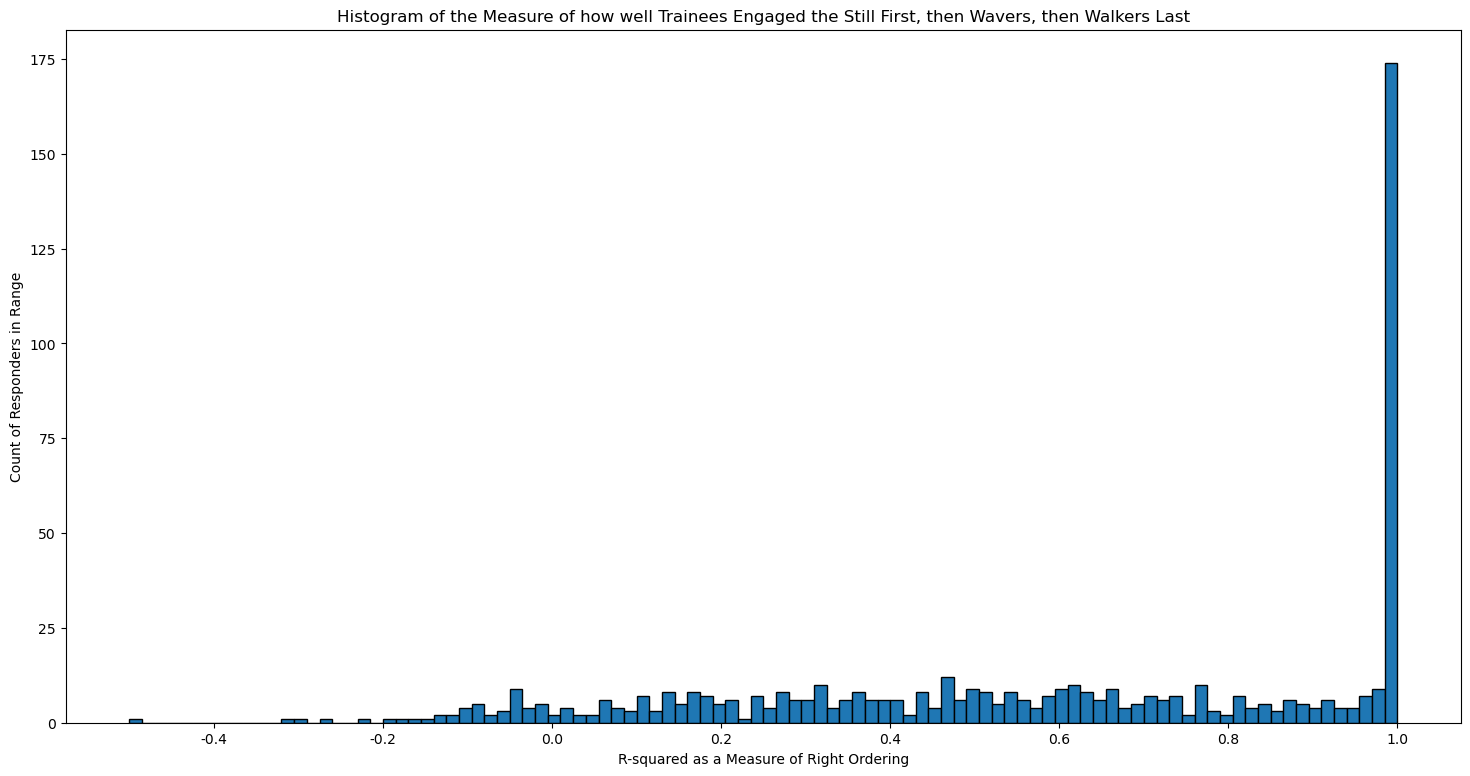

In [6]:

# Display a histogram of the distribution of the measure of
# how well responders engaged the still first, then wavers, then walkers last
xlabel = 'R-squared as a Measure of Right Ordering'
get_xtick_text = lambda text_obj: round(text_obj.get_position()[0], 2)
title = 'Histogram of the Measure of how well Trainees Engaged the Still First, then Wavers, then Walkers Last'
ylabel = 'Count of Responders in Range'
mask_series = (engagment_sort_df.scene_type == 'Normal') & (engagment_sort_df.is_scene_aborted == False)
ax = nu.plot_histogram(engagment_sort_df[mask_series], 'rsquared_adj', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=False)

In [7]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
mask_series = (engagment_sort_df.scene_type == 'Normal') & (engagment_sort_df.is_scene_aborted == False)
columns_list = [
    'rsquared_adj'
]
df = engagment_sort_df[mask_series][columns_list]
display(nu.get_statistics(df, columns_list).applymap(lambda x: round(x, 1), na_action='ignore').T)

,mean,mode,median,SD,min,25%,50%,75%,max
rsquared_adj,0.6,1.0,0.6,0.4,-0.5,0.3,0.6,1.0,1.0


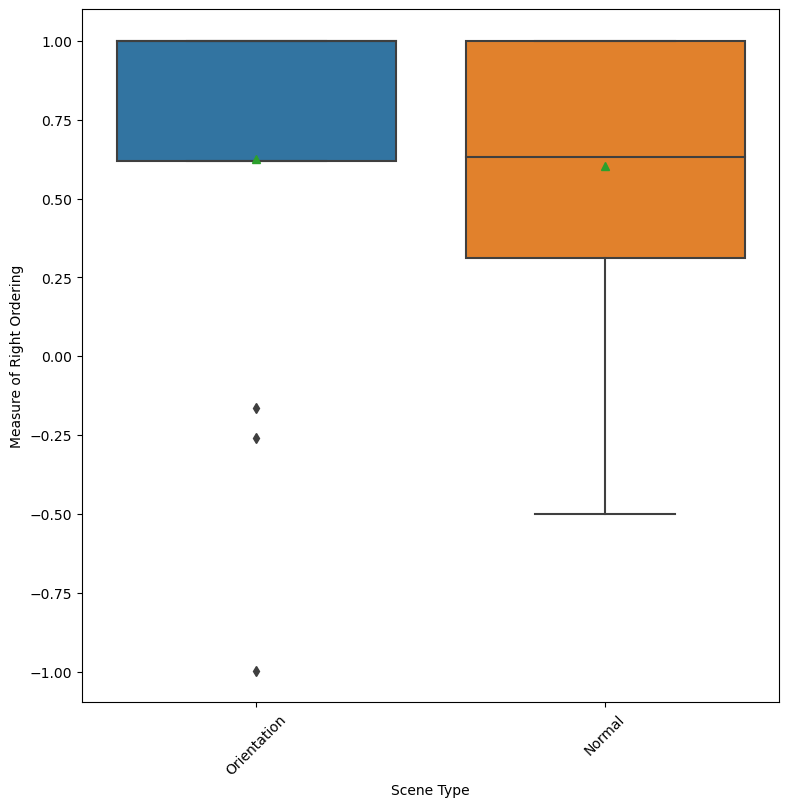

In [8]:

# Filter out anything after 16 minutes per Nicholas Kman
mask_series = (engagment_sort_df.is_scene_aborted == False)
df = engagment_sort_df[mask_series]
nu.plot_grouped_box_and_whiskers(df, 'scene_type', 'rsquared_adj', 'Scene Type', 'Measure of Right Ordering', transformer_name=None, is_y_temporal=False)

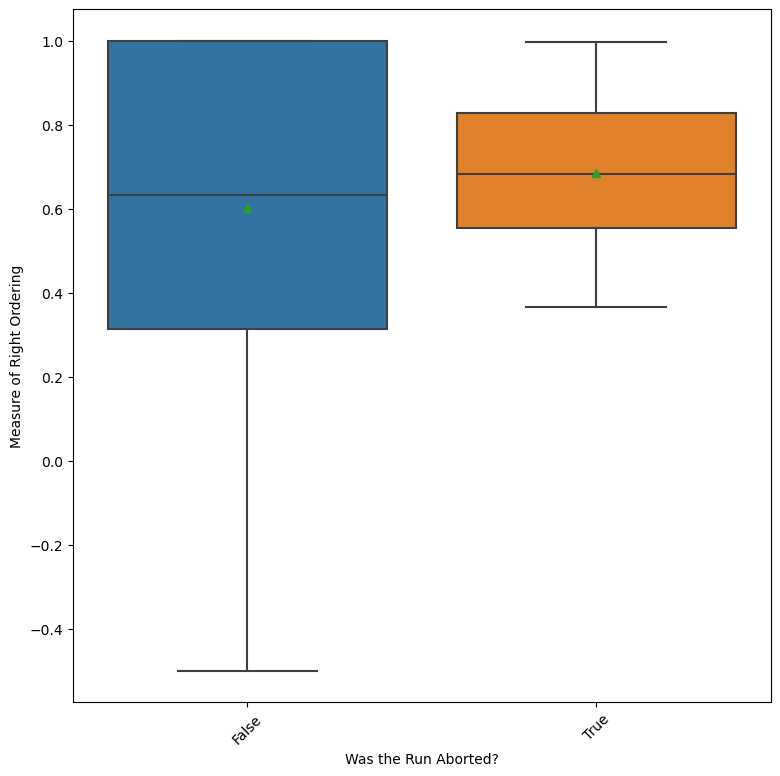

In [9]:

mask_series = (engagment_sort_df.scene_type == 'Normal')
df = engagment_sort_df[mask_series]
nu.plot_grouped_box_and_whiskers(df, 'is_scene_aborted', 'rsquared_adj', 'Was the Run Aborted?', 'Measure of Right Ordering', transformer_name=None, is_y_temporal=False)


## How many responders did the right order? Should be a percentage of all responders


In [10]:

mask_series = (engagment_sort_df.scene_type == 'Normal') & (engagment_sort_df.is_scene_aborted == False)
total_count = engagment_sort_df[mask_series].shape[0]
mask_series &= (engagment_sort_df.rsquared_adj == 1.0)
correct_count = engagment_sort_df[mask_series].shape[0]
percentage_tag_correct = 100*correct_count/total_count
print(f'{percentage_tag_correct:.2f}% of all responders engaged the still first, then wavers, then walkers last, in an ideal sequence.')

19.28% of all responders engaged the still first, then wavers, then walkers last, in an ideal sequence.
